# Test Delight on DESC-DC2 simulation  in the context of  Vera C. Rubin Obs (LSST) 


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 22 2022



- run at NERSC with **desc-python** python kernel.


Instruction to have a **desc-python** environnement:
- https://confluence.slac.stanford.edu/display/LSSTDESC/Getting+Started+with+Anaconda+Python+at+NERSC


This environnement is a clone from the **desc-python** environnement where package required in requirements can be addded according the instructions here
- https://github.com/LSSTDESC/desc-python/wiki/Add-Packages-to-the-desc-python-environment

We will use the parameter file "tmps/parametersTestRail.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys,os
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

# Initialisation

In [2]:
workdir = "tmp"

# Configuration parameters

- now parameters are generated in a dictionnary

In [3]:
list_of_files = os.listdir(workdir)
list_of_files.remove('data') 
list_of_files.remove('delight_data') 
if '.ipynb_checkpoints' in list_of_files:
    list_of_files.remove('.ipynb_checkpoints')
list_of_configfiles = sorted(list_of_files)

In [4]:
list_of_configfiles

['parametersTest-Sens.cfg',
 'parametersTest-VC1e4_ell1e6.cfg',
 'parametersTest-chunks.cfg',
 'parametersTest.cfg',
 'parametersTest_1.cfg',
 'parametersTest_10.cfg',
 'parametersTest_11.cfg',
 'parametersTest_12.cfg',
 'parametersTest_13.cfg',
 'parametersTest_14.cfg',
 'parametersTest_15.cfg',
 'parametersTest_16.cfg',
 'parametersTest_17.cfg',
 'parametersTest_18.cfg',
 'parametersTest_19.cfg',
 'parametersTest_2.cfg',
 'parametersTest_20.cfg',
 'parametersTest_21.cfg',
 'parametersTest_21_VC1e4.cfg',
 'parametersTest_21_ellSig1e6.cfg',
 'parametersTest_21_zSig2.cfg',
 'parametersTest_3.cfg',
 'parametersTest_4.cfg',
 'parametersTest_5.cfg',
 'parametersTest_6.cfg',
 'parametersTest_7.cfg',
 'parametersTest_8.cfg',
 'parametersTest_9.cfg']

In [5]:
configfilename = 'parametersTest.cfg'
configfullfilename = os.path.join(workdir,configfilename)

# Analyze the outputs

In [6]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile(configfullfilename, verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [7]:
# Load the PDF files
metrics = np.loadtxt(params['metricsFile'])
metricscww = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

In [8]:
# Load the results from LEPHARE
########
# PARAMETERS TO SET
lephareRoot='/pbs/throng/lsst/users/jocheval/MYLEPHARE/LEPHARE/LSST'
fileIn=lephareRoot+'/zphot_long.out'

# Number of the filter start at 0
selFilt=1   # filter for the selection in mag
uFilt=0
bFilt=1
rFilt=2
zFilt=3
jFilt=4
KsFilt=5

# Array in redshift and mag, isolate extreme values
range_z   = [0,1,2,3,6]
z_min, z_max = np.amin(range_z), np.amax(range_z)
range_mag = [15.,22.5,23.5,25,28]
mag_min, mag_max = np.amin(range_mag), np.amax(range_mag)

########
# READ THE INPUT FILE
# Read the first argument with the name of the photo-z output catalogue
catIn=open(fileIn,'r')
print("Name of the photo-z catalogue : ",fileIn)

# Loop over the filters
nbFilt=6
magst=""
idmagst=""
# create the string to read the mag
for i in range(nbFilt) :
    magst=magst+",mag"+str(i)
    idmagst=idmagst+","+str(i+20)
# create the string to read the error mag
for i in range(nbFilt) :
    magst=magst+",emag"+str(i)
    idmagst=idmagst+","+str(i+20+nbFilt)
# create the string to read the kcor
for i in range(nbFilt) :
    magst=magst+",kcor"+str(i)
    idmagst=idmagst+","+str(i+20+2*nbFilt)
# create the string to read the absolute mag
for i in range(nbFilt) :
    magst=magst+",absmag"+str(i)
    idmagst=idmagst+","+str(i+20+3*nbFilt)
# create the string to read the uncertainties on absolute mag
for i in range(nbFilt) :
    magst=magst+",eabsmag"+str(i)
    idmagst=idmagst+","+str(i+20+4*nbFilt)
# create the string for absolute mag filters
for i in range(nbFilt) :
    magst=magst+",mabsfilt"+str(i)
    idmagst=idmagst+","+str(i+20+5*nbFilt)

lastIdMagst=int(idmagst.split(',')[-1])
lastString=",{},{},{},{}".format(lastIdMagst+1, lastIdMagst+2, lastIdMagst+3, lastIdMagst+4)

# Extract from the ascii file
commandst = "Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis"+magst+",scale,nbFilt,context,zs= np.loadtxt(catIn, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"+idmagst+lastString+"), unpack=True )"
#commandst = "Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis"+magst+",scale,nbFilt,context,zs= np.loadtxt(catIn, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"+idmagst+",254,255,256,257), unpack=True )"
# transform the string into a command
print(commandst)
exec(commandst)
print(zp[0], zs[0], zp[1000], zs[1000])

##################################################
#    CONDITION FOR SELECTION
# Mag use to select the sample
mag=eval("mag"+str(selFilt))
# General condition to select the galaxies in the expected z/mag range
cond = (zp>z_min) & (zp<z_max) & (mag>mag_min) & (mag<mag_max) 
# condition to select stars
condstar = (chis<chi)
# condition to select galaxies
condgal =  (~condstar)
# condition to select spectroscopic redshifts
condspec = (zs>0) & (zs<9)

Name of the photo-z catalogue :  /pbs/throng/lsst/users/jocheval/MYLEPHARE/LEPHARE/LSST/zphot_long.out
Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis,mag0,mag1,mag2,mag3,mag4,mag5,emag0,emag1,emag2,emag3,emag4,emag5,kcor0,kcor1,kcor2,kcor3,kcor4,kcor5,absmag0,absmag1,absmag2,absmag3,absmag4,absmag5,eabsmag0,eabsmag1,eabsmag2,eabsmag3,eabsmag4,eabsmag5,mabsfilt0,mabsfilt1,mabsfilt2,mabsfilt3,mabsfilt4,mabsfilt5,scale,nbFilt,context,zs= np.loadtxt(catIn, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59), unpack=True )
0.2397 0.023 0.4588 0.46


In [9]:
# Load the PDZ from LEPHARE
pdzOut=lephareRoot+'/pdzOut.pdz'
pdzRange = np.arange(0.01, 3.02, 0.01)
print(pdzRange.shape)
pdzRange = np.concatenate((np.array([0.0]), pdzRange, np.array([3.01])))
print(pdzRange[0], pdzRange[-1], pdzRange[-2], pdzRange[-3])
print(pdzRange.shape)
pdzPhare = np.loadtxt(pdzOut)
print(pdzPhare.shape)
#pdzPhare = pdzPhare[:, 1:]
#print(pdzPhare.shape)

(301,)
0.0 3.01 3.01 3.0
(303,)
(7552, 304)


2702 0.7823166639401706 8063655919.0 8063655919.0 True
5793 1.0918473956029358 8065285045.0 8065285045.0 True
3459 0.8885316646613146 8064190152.0 8064190152.0 True
6676 1.2018295431453137 8065871101.0 8065871101.0 True
9419 1.682768171956471 8069517031.0 8069517031.0 True
7819 1.324294273744412 8066932343.0 8066932343.0 True
348 0.18429266737221295 8062526905.0 8062526905.0 True
815 0.3134679927079769 8062614212.0 8062614212.0 True
9540 1.6337829266946553 8069032406.0 8069032406.0 True
269 0.15609156523490153 8062518806.0 8062518806.0 True
2870 0.8117919512338942 8063829857.0 8063829857.0 True
7600 1.3007006711922386 8066510194.0 8066510194.0 True
4950 1.0453597521900435 8065000348.0 8065000348.0 True
4047 0.9187953260365869 8064196212.0 8064196212.0 True
4443 0.9902893676680387 8064662449.0 8064662449.0 True
8500 1.4714672326541969 8067704738.0 8067704738.0 True
4145 0.9269144618588938 8064435916.0 8064435916.0 True
1871 0.6035838842266803 8063123896.0 8063123896.0 True
510 0.2220058

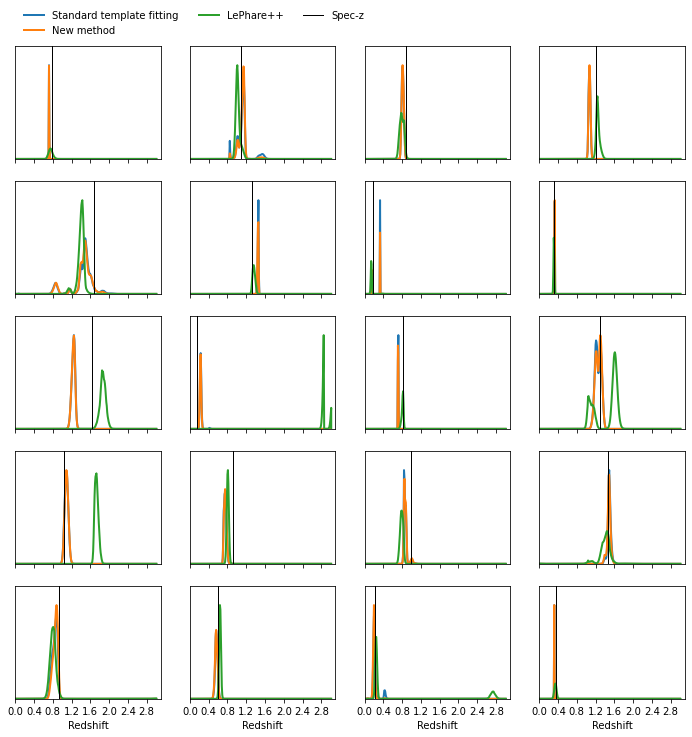

In [10]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(12, 12), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    zspec=fluxredshifts[k, redshiftColumn]
    #print(zspec, np.where(zs == zspec))
    dummy=np.array([])
    for z in zs:
        dummy=np.append(dummy, (z-zspec))
    dummy=np.absolute(dummy)
    galId=Id[np.argmin(dummy)]
    print(k, zspec, galId, pdzPhare[np.argmin(dummy),0], galId == pdzPhare[np.argmin(dummy),0])#, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db" 
    axs[ik].plot(pdzRange, pdzPhare[np.argmin(dummy), 1:], lw=lw, label='LePhare++')  #, c="#3498db"
    axs[ik].axvline(zspec, c="k", lw=1, label='Spec-z')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :], pdzPhare[np.argmin(dummy), 1:])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


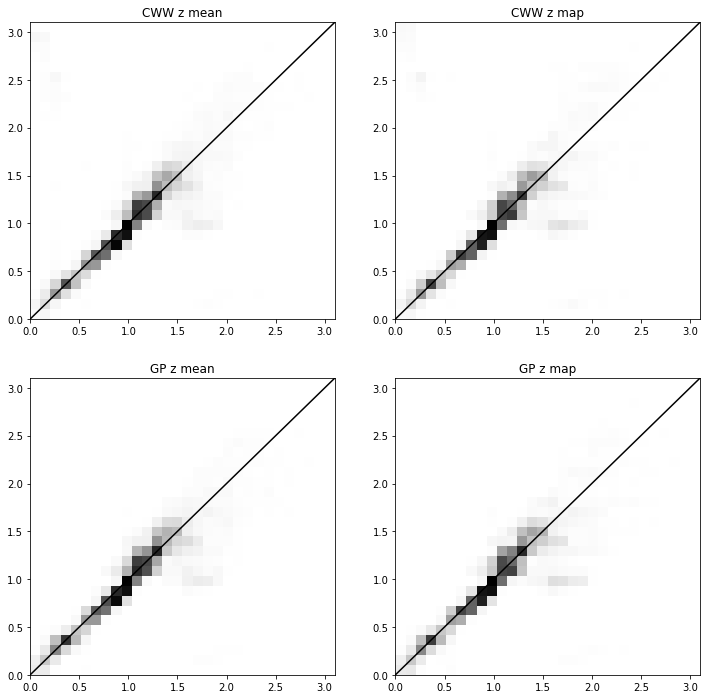

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
zmax = 3.1
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
#fig.tight_layout()

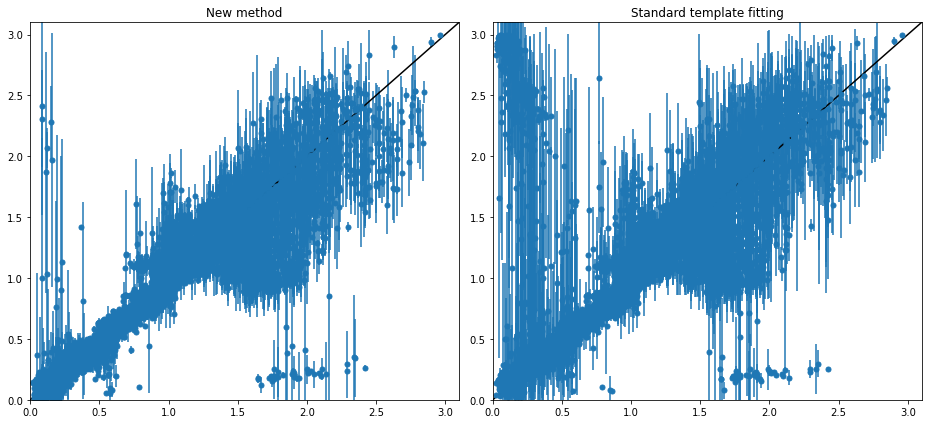

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

0.2397 24 0.30156952174032764
0.4588 46 0.4661982238118165
0.8081 81 0.2224925985336018
0.8435 85 0.3204758016655388
1.134 114 0.6065721380671606
1.017 102 0.42362877049143527
1.58 159 0.41261966865907135
1.853 186 0.2917849438872756


Text(0.5, 1.0, 'New method')

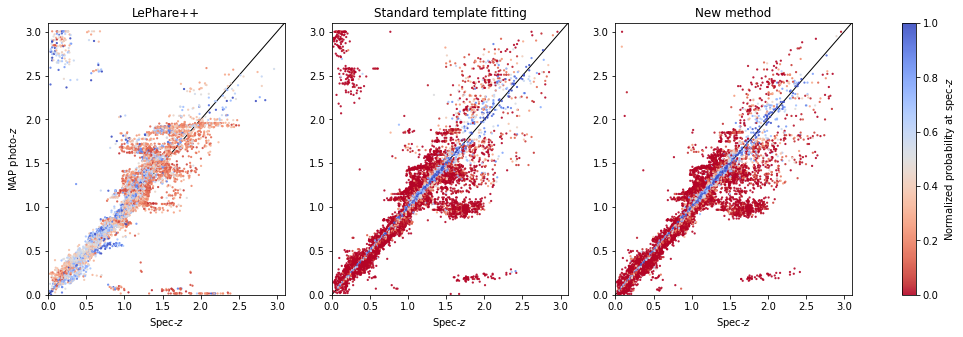

In [13]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
pdfatZlePha=[]
loc=-1
for z in zp:
    loc+=1
    if loc%1000 == 0:
        print(z, int(1+(z/0.01)), pdzPhare[loc, int(1+(z/0.01))]/np.max(pdzPhare[:,int(1+(z/0.01))]))
    pdfatZlePha.append(pdzPhare[loc, int(1+(z/0.01))]/np.max(pdzPhare[:,int(1+(z/0.01))]))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
vs = axs[0].scatter(zs, zp, 
                    s=s, c=pdfatZlePha, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[2].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(3):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')
axs[0].set_title('LePhare++')
axs[1].set_title('Standard template fitting')
axs[2].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.